In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from numba import njit
from numba import prange
import time

NumPy version: 1.26.4


In [9]:
# create original unit cell lattice vectors
a1 = (np.sqrt(3)/2, 0.5)
a2 = (-np.sqrt(3)/2, 0.5)
a3 = (0.0, -1.0)

# Create the original unit cell reciprocal Lattice
g1 = 2*np.pi/3*np.array([np.sqrt(3), 3.0])
g2 = 2*np.pi/3*np.array([-np.sqrt(3), 3.0])

# larger unit cell basis vectors (different gauge)
b1m = 3*a1
b2m = a2

#reciprocal lattice vectors of larger unit cell (different gauge)
h1m = g1/3
h2m = g2

In [10]:
# create momentum grid, spanned by vectors vec1 and vec2

def get_electron_mom_grid(L3, vec1, vec2):
    dg1 = vec1 / L3
    dg2 = vec2 / L3

    # range of indices, symmetric around zero
    idx = np.arange(-L3//2, L3//2)
    idy = np.arange(-L3//2, L3//2)

    EmomGrid = np.zeros((L3*L3, 2), dtype=float)
    EmomGridMat = np.zeros((L3, L3, 2), dtype=float)

    for i, n1 in enumerate(idx):
        for j, n2 in enumerate(idy):
            q_vec = n1 * dg1 + n2 * dg2
            EmomGrid[i*L + j] = q_vec
            EmomGridMat[i, j] = q_vec

    return EmomGrid, EmomGridMat

def get_mom_grid(L, vec1, vec2):
    """
    Build a 2D momentum grid centered around q = (0, 0)
    for a lattice with reciprocal vectors vec1, vec2.
    """
    dg1 = vec1 / L
    dg2 = vec2 / (3*L)

    # range of indices, symmetric around zero
    idx = np.arange(-L//2, L//2)
    idy = np.arange(-(3*L)//2, (3*L)//2)

    momGrid = np.zeros((3*L*L, 2), dtype=float)
    momGridMat = np.zeros((L, 3*L, 2), dtype=float)

    for i, n1 in enumerate(idx):
        for j, n2 in enumerate(idy):
            q_vec = n1 * dg1 + n2 * dg2
            momGrid[i*L + j] = q_vec
            momGridMat[i, j] = q_vec

    return momGrid, momGridMat

# Hamiltonian for the Partons
def Ham_Partons(k, vals, a1, a2, a3): #Bloch-Hamiltonian H(k) for partons, a1, a2, a3 are lattice vectors/ nearest neighbor
    t1, t2, t3, omg = vals
    ka1 = np.inner(k, a1)
    ka2 = np.inner(k, a2)
    ka3 = np.inner(k, a3)
    #np.inner computes the inner product of two arrays
    
    # nearest-neighbor hopping
    ek1 = np.exp(-1j*ka1)
    ek2 = np.exp(-1j*ka2)
    ek3 = np.exp(-1j*ka3)
    hk1 = t1*np.array([[ek2, np.exp(-1j*omg)*ek1, np.exp(1j*omg)*ek3],
                    [np.exp(-1j*omg)*ek3, np.exp(1j*omg)*ek2, ek1],
                    [np.exp(1j*omg)*ek1, ek3, np.exp(-1j*omg)*ek2]])

    return hk1 + np.conj(hk1.T)

# Get the eigenvalues and eigenvectors of the Hamiltonians with vals1 and vals2
def get_evals_evecs(L, vals, a1, a2, a3, h1m, h2m):

    kGrid, kGridMat = get_mom_grid(L, h1m, h2m)

    evals = np.full((L, 3*L, 3), None, dtype=float)
    evecs = np.full((L, 3*L, 3, 3), None, dtype=np.complex128)


    for kk in range(L):
        for pp in range(3*L):
            evals[kk, pp], evecs[kk, pp] = np.linalg.eigh(Ham_Partons(kGridMat[kk, pp], vals, a1, a2, a3))

    return evals, evecs

# get the Fermi energy
def get_energy(bands, dn=0, nu=1, nBands=3):
    ''' 
    bands_ has shape (L, 3*L, nBands)
    '''
    L = len(bands[:, 0, 0])         
    bands_new = np.reshape(bands, (nBands*3*L**2))
    bands_new = np.sort(bands_new)

    fillInt = int(nu*3*L**2+dn)
    energ = 1./(3*L**2) * np.sum(bands_new[:fillInt])
    return energ

#get the chemical potential
def get_chempot(bands, nu=1, nBands=3):
    L = len(bands[:, 0, 0]) 
    e1 = get_energy(bands, nu=nu, dn=1, nBands=nBands)*3*L**2
    em1 = get_energy(bands, nu=nu, dn=-1, nBands=nBands)*3*L**2
    return 0.5*(e1-em1)

print('everything works so far')

#convert the energy eigenenergies to ksi == E-mu
def get_ksi(bands, mu):
    L = len(bands[:, 0, 0])
    KSI = np.zeros((L, 3*L, 3), dtype=float)
    for kk in range(L):
        for pp in range(3*L):
            for band in range(3):
                KSI[kk, pp, band] = bands[kk, pp, band]-mu
    return KSI

everything works so far


In [11]:
#Define general parameters
L=10 #number of k-points in each direction

#Parameters for Partons with C= -1, -1, +2 (all 3 partons in nu=1/3, charge -e/3)
#take the values vals from Fabian's Code
vals1 = 1/9, 0.0, 0.0, 2*np.pi/3

#Parameters for Partons with C= -1, -1, +2 (1 parton species in nu=2/3 with charge -e/3)
#take the values vals from Fabian's Code
vals21 = 4/9, 0.0, 0.0, 2*np.pi/3

#Parameters for Partons with C= +2, -1, -1 (2 partons of parton species in nu=2/3, charge 2e/3)
#take the values vals from Fabian's Code
vals22 = -4/9, 0.0, 0.0, -2*np.pi/3

#get eigenvectors and eigenenergies/banddispersion
evals1, evecs1 = get_evals_evecs(L, vals1, a1, a2, a3, h1m, h2m)
evals21, evecs21 = get_evals_evecs(L, vals21, a1, a2, a3, h1m, h2m)
evals22, evecs22 = get_evals_evecs(L, vals22, a1, a2, a3, h1m, h2m)

#compute Fermi-energy and the chemical potential for nu=1/3 -> Partons have nu=1
E_F11 = get_energy(evals1, 0, 1, 3) 
mu_11 = get_chempot(evals1, 1, 3)

#compute Fermi-energy and the chemical potential for nu=2/3 -> Partons have nu=2
    #for charge -e/3 partons
E_F21 = get_energy(evals21, 0, 2, 3) 
mu_21 = get_chempot(evals21, 2, 3)
    #for charge 2e/3 partons
E_F22 = get_energy(evals22, 0, 2, 3) 
mu_22 = get_chempot(evals22, 2, 3)

#define Fermi-Dirac and Bose-Einstein summands

#create the grid spanned by h1m, h2m
kGrid, kGridMat = get_mom_grid(L, h1m, h2m)
kGrid_e, kGridMat_e = get_electron_mom_grid(3*L, g1, g2)

#get ksi = energy - chempot
ksi1 = get_ksi(evals1, mu_11)
ksi21 = get_ksi(evals21, mu_21)
ksi22 = get_ksi(evals22, mu_22)

In [12]:
def get_C_mat_mat_vec(omg_mats, evecs, bands):
    """
    Vectorized version of get_C_mat_mat.

    Parameters
    ----------
    omg_mats : (N,) complex (or float) array
        Matsubara frequencies ω_n. If real, you can add a small +i*eta shift.
    evecs : (..., a, m) complex array
        Eigenvectors with indices (k, p, a, m) where a is orbital (size 3).
    bands : (k, p, m) real/complex array
        Band energies ε_{kpm}.
    eta : float, optional
        Small positive broadening; uses ω -> ω + i*eta.

    Returns
    -------
    C_mat : (k, p, a, b, N) complex array
        Orbital-resolved matrix for each (k,p) and ω_n:
        C^{ab}_{kp}(ω_n) = Σ_m Z^{ab}_{kpm} / (ω_n - ε_{kpm}),
        with Z^{ab}_{kpm} = evecs_{kpam} * evecs^*_{kpbm}.
    """
    # Projector weights Z_{k p a b m}
    Z_mat = np.einsum('kpam,kpbm->kpabm', evecs, np.conj(evecs))  # (k,p,3,3,m)

    # 1 / (ω_n - ε) for each (k,p,m,n)
    denom_inv = 1.0 / ( (omg_mats[None, None, None, :])  # (1,1,1,N)
                        - bands[..., None] )                      # (k,p,m,1)
    # Make shapes align to (k,p,m,N)
    denom_inv = denom_inv  # (k,p,m,N)

    # Sum over band index m:  (k,p,a,b,m) * (k,p,m,n) -> (k,p,a,b,n)
    C_mat = np.einsum('kpabm,kpmn->kpabn', Z_mat, denom_inv)

    return C_mat

beta = 50 #inverse temperature beta = 50
M = 1000 #number of negative Matsubara frequencies = number of positive Matsubara frequencies = M
omg_mats = 1j*np.pi*(2*np.arange(-M, M+1)+1)/ beta  #Matsubara frequencies, N=2*M+1

G_Parton1_iwn = get_C_mat_mat_vec(omg_mats, evecs1, ksi1) #nu = 1/3 parton with charge -e/3, 1 band filled with C=-1

G_Parton21_iwn = get_C_mat_mat_vec(omg_mats, evecs21, ksi21) #nu = 2/3 parton with charge -e/3, 2 bands filled C_ges = -1-1=-2
G_Parton22_iwn = get_C_mat_mat_vec(omg_mats, evecs22, ksi22) #nu = 2/3 2 partons with charge 2e/3, 2 bands filled C_ges = 2-1 =+1

In [ ]:

@njit
def get_Z_mat(evecs):
    '''
    evecs has shape (L, 3*L, 3, 3)
    '''
    L = evecs.shape[0]
    Z_mat = np.zeros((L, 3*L, 3, 3, 3), dtype=np.complex128)  # Pre-allocate Z_mat with the correct shape

    # Compute the contraction manually
    for k in range(L):
        for p in range(3*L):
            for m in range(3):
                for a in range(3):
                    for b in range(3):
                        Z_mat[k, p, a, b, m] += evecs[k, p, a, m] * np.conj(evecs[k, p, b, m])  # Perform summation

    return Z_mat

@njit
def n_F(eps, beta=50):
    return 1/(1+np.exp(beta * eps))

@njit(parallel=True)
def dChi_woZ(x, y, Omg, eta=1e-2):
    return (n_F(y, beta)-n_F(x, beta))/(Omg + eta - x + y)

@njit(parallel=True)
def get_Chi0_1P_part(Z, ksi, omega, eta=1e-2):
    L = len(ksi[:, 0, 0])
    N = len(omega)
    Chi0 = np.zeros((L, 3*L, 3, 3, N), dtype=np.complex128)
    for kk in prange(L):
        for pp in prange(3*L):
            for a in prange(3):
                for b in prange(3):
                    for qx in prange(L):
                        for qy in prange(3*L):
                            for n in prange(N):
                                for m1 in prange(3):
                                    for m2 in prange(3):
                                        Chi0[kk, pp, a, b, n] += Z[qx, qy, a, b, m1] * Z[(qx-kk)%L, (qy-pp)%(3*L), a, b, m2] * dChi_woZ(ksi[qx, qy, m1], ksi[(qx-kk)%L, (qy-pp)%(3*L), m2], omega[n], eta)
    return 1/(3*L**2)*Chi0

Z11 = get_Z_mat(evecs1)
Z21 = get_Z_mat(evecs21)
Z22 = get_Z_mat(evecs22)
omega_real1 = np.linspace(0.0, 3, 300, dtype=np.complex128)
omega_real2 = np.linspace(0.0, 10, 300, dtype=np.complex128)

Chi01_1Ppart = 3*get_Chi0_1P_part(Z11, ksi1, omega_real1)
Chi02_1Ppart = get_Chi0_1P_part(Z21, ksi21, omega_real2) + 2*get_Chi0_1P_part(Z22, ksi22, omega_real2)

/bin/bash: line 1: conda: command not found


NumPy version: 1.26.4


ModuleNotFoundError: No module named 'numba'

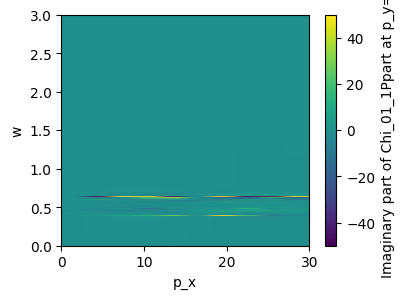

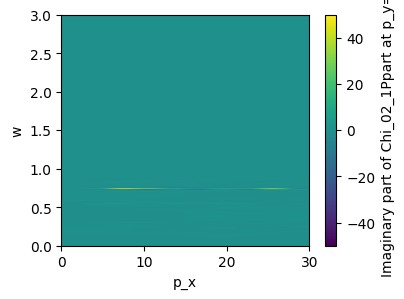

In [ ]:
def get_Chi0_ab_x_iwn(Chi0_ab_q_v):
    return np.fft.ifftn(np.fft.ifftshift(Chi0_ab_q_v, axes=(0, 1)), axes=(0,1))

def get_Chi0_r_iwn(Chi0_ab_x_v):
    L = len(Chi0_ab_x_v[:,0,0,0,0])
    l = len(Chi0_ab_x_v[0,0,:,0,0])
    N = len(Chi0_ab_x_v[0,0,0,0,:])
    Chi0_r_v = np.zeros((3*L,3*L,N))
    for xx in range(L):
        for yy in range(3*L):
            for a in range(l):
                Chi0_r_v[3*xx+a,yy,:] = Chi0_ab_x_v[xx,yy,a,0,:]
    return Chi0_r_v

def get_Chi0_k_v(Chi0_r_tau):
    return np.fft.fftn(Chi0_r_tau, axes= (0,1))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.imshow(np.imag(np.transpose(Chi01_1Ppart[:, 15, 2, 1, :])), extent=(0, 3*L, 0, 3), origin='lower', aspect='auto', vmin=-50, vmax=50)
plt.colorbar(label='Imaginary part of Chi_01_1Ppart at p_y=0')
plt.xlabel('p_x')
plt.ylabel('w')
plt.show()

plt.figure(figsize=(4, 3))
plt.imshow(np.imag(np.transpose(Chi02_1Ppart[:, 15, 2, 1, :])), extent=(0, 3*L, 0, 3), origin='lower', aspect='auto', vmin=-50, vmax=50)
plt.colorbar(label='Imaginary part of Chi_02_1Ppart at p_y=0')
plt.xlabel('p_x')
plt.ylabel('w')
plt.show()